In [1]:
import numpy as np
import scipy.misc
import pylab
import torch
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wavelets_pytorch_2.alltorch.wavelets import Morlet, Ricker, DOG, Paul
from wavelets_pytorch_2.alltorch.transform import WaveletTransformTorch #WaveletTransform, 
from IPython.display import clear_output
from tqdm import tqdm_notebook,tqdm
from sklearn.preprocessing import normalize
import matplotlib.image as mpimg
import time
# from wavelets_pytorch_2.backup_pytorchwavelets.wavelets import Morlet, Ricker, DOG
# from wavelets_pytorch_2.backup_pytorchwavelets.transform import WaveletTransformTorch #WaveletTransform, 

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


#from examples.plot import plot_scalogram

### Scalogram defn input

In [2]:
def plot_scalogram(power, scales, t, normalize_columns=True, cmap=None, ax=None, scale_legend=True):
    """
    Plot the wavelet power spectrum (scalogram).

    :param power: np.ndarray, CWT power spectrum of shape [n_scales,signal_length]
    :param scales: np.ndarray, scale distribution of shape [n_scales]
    :param t: np.ndarray, temporal range of shape [signal_length]
    :param normalize_columns: boolean, whether to normalize spectrum per timestep
    :param cmap: matplotlib cmap, please refer to their documentation
    :param ax: matplotlib axis object, if None creates a new subplot
    :param scale_legend: boolean, whether to include scale legend on the right
    :return: ax, matplotlib axis object that contains the scalogram
    """

    if not cmap: cmap = plt.get_cmap("plasma")#("coolwarm")
    if ax is None: fig, ax = plt.subplots()
    if normalize_columns: power = power/np.max(power, axis=0)

    T, S = np.meshgrid(t, scales)
    cnt = ax.contourf(T, S, power, 500, cmap=cmap)

    # Fix for saving as PDF (aliasing)
    for c in cnt.collections:
        c.set_edgecolor("face")

    ax.set_yscale('log')
    ax.set_ylabel("Scale (Log Scale)")
    ax.set_xlabel("Time (s)")
    ax.set_title("Wavelet Power Spectrum")

    if scale_legend:
        def format_axes_label(x, pos):
            return "{:.2f}".format(x)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(cnt, cax=cax, ticks=[np.min(power), 0, np.max(power)],
                     format=ticker.FuncFormatter(format_axes_label))

    return ax

In [3]:
dat = np.load('../seg_dataset/X.npy')
label = np.load('../seg_dataset/Y.npy')
#dat = normalize(dat,axis=0)
fps = 150
dt  = 1.0/fps
dt1 = 1.0/fps
dj  = 0.125
unbias = False
batch_size = 32
#wavelet = Morlet(w0=2)
wavelet = Paul(m=8)

def show(data):
    pylab.jet()
    pylab.imshow(data)
    pylab.colorbar()
    pylab.show()
    pylab.clf()
    
x = np.linspace(0, 1, num=dat[0].shape[0])
dt = 1
#label[np.where(label==1)] = 0
#label[np.where(label==3)] = 0
# label = normalize(label,axis=1)
print(dat.shape, label.shape)
print(np.unique(label))

(1257, 150) (1257, 150)
[0. 1. 2. 3.]


In [13]:
ind = np.random.randint(0,dat.shape[0],1).squeeze()

### Power scale conversion - ECG & Labels

In [14]:
ecg = torch.from_numpy(dat[ind]).float()#, afib_dat[ind].shape
wa_ecg_torch = WaveletTransformTorch(dt, dj, wavelet, unbias=unbias, cuda=True)
power_ecg_torch = wa_ecg_torch.power(ecg).type(torch.FloatTensor)#.numpy())
scales_ecg_torch = torch.from_numpy(wa_ecg_torch.fourier_periods).type(torch.FloatTensor)
lab = torch.from_numpy(label[ind]).float()
wa_label_torch = WaveletTransformTorch(dt, dj, wavelet, unbias=unbias, cuda=True)
power_label_torch = wa_label_torch.power(lab).type(torch.FloatTensor)#.numpy())
scales_label_torch = torch.from_numpy(wa_label_torch.fourier_periods).type(torch.FloatTensor)

In [15]:
wa_ecg_torch._cwt_op.shape

(47, 150)

In [16]:
scales_ecg_torch.shape, scales_label_torch.shape
ecg_recon = wa_ecg_torch.reconstruction(power_ecg_torch,scales_ecg_torch)
label_recon = wa_label_torch.reconstruction(power_label_torch,scales_label_torch)
# plt.plot(lab.numpy())
# plt.show()
# plt.plot(label_recon)
# plt.show()
# print(np.unique(label))
# # power_label_torch

Text(0.5,1,'Label reconstructed signal')

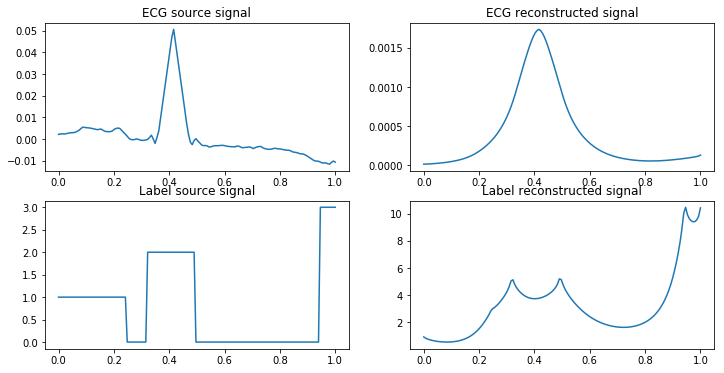

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12,6))
ax = ax.flatten()
ax[0].plot(x, dat[ind])
ax[0].set_title(r'ECG source signal')
# ax[0].set_xlabel('Samples')

ax[1].plot(x, ecg_recon)
ax[1].set_title(r'ECG reconstructed signal')
# ax[1].set_xlabel('Samples')

ax[2].plot(x, label[ind])
ax[2].set_title(r'Label source signal')
# ax[3].set_xlabel('Samples')

ax[3].plot(x, label_recon)
ax[3].set_title(r'Label reconstructed signal')
# ax[3].set_xlabel('Samples')


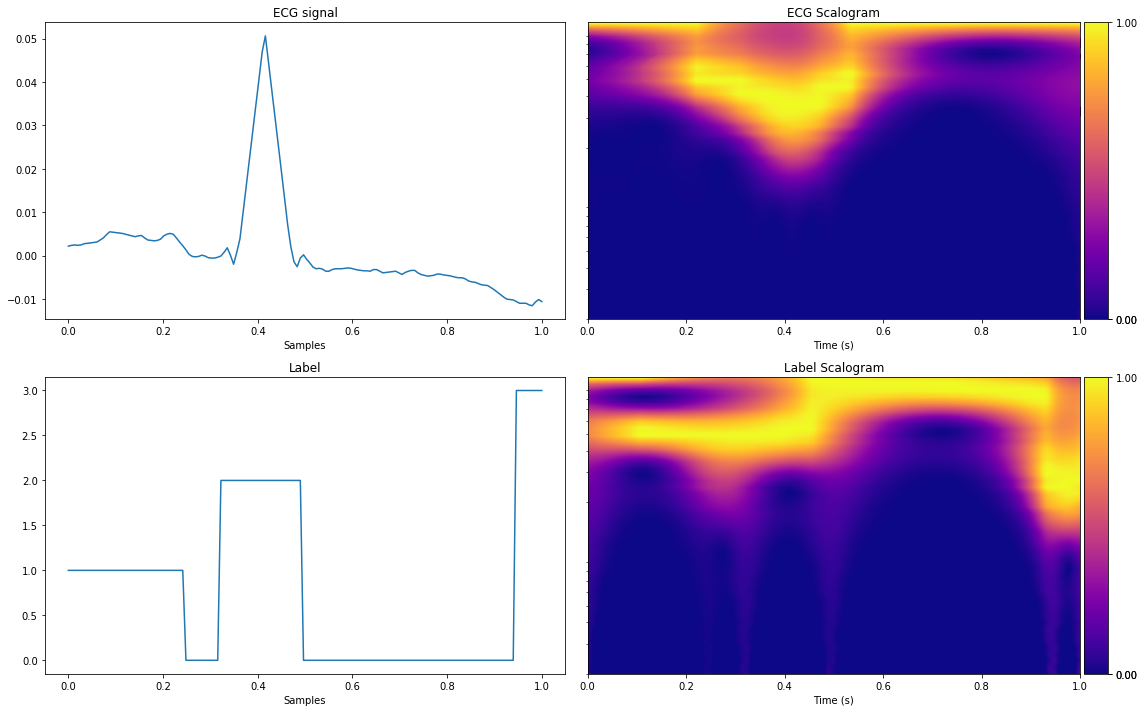

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(16,10))
ax = ax.flatten()
ax[0].plot(x, dat[ind])
ax[0].set_title(r'ECG signal')
ax[0].set_xlabel('Samples')
plot_scalogram(power_ecg_torch.numpy(), scales_ecg_torch.numpy(), x, ax=ax[1])
#ax[1].axhline(1.0 / random_frequencies[0], lw=1, color='k')
ax[1].set_title('ECG Scalogram')#.format(1.0/random_frequencies[0]))
ax[1].set_ylabel('')
ax[1].set_yticks([])

ax[2].plot(x, label[ind])
ax[2].set_title(r'Label')
ax[2].set_xlabel('Samples')
plot_scalogram(power_label_torch.numpy(), scales_label_torch.numpy(), x, ax=ax[3])
#ax[1].axhline(1.0 / random_frequencies[0], lw=1, color='k')
ax[3].set_title('Label Scalogram')#.format(1.0/random_frequencies[0]))
ax[3].set_ylabel('')
ax[3].set_yticks([])

# plot_scalogram(power_torch1.numpy(), scales_torch1.numpy(), t, ax=ax[2])
# #ax[1].axhline(1.0 / random_frequencies[0], lw=1, color='k')
# ax[2].set_title('Scalogram dt=10/fs')#.format(1.0/random_frequencies[0]))
# ax[2].set_ylabel('')
# ax[2].set_yticks([])
plt.tight_layout()
plt.show()


In [81]:
scales_ecg_torch.shape, power_ecg_torch.shape, scales_label_torch.shape, power_label_torch.shape

(torch.Size([50]),
 torch.Size([50, 150]),
 torch.Size([50]),
 torch.Size([50, 150]))

In [ ]:
random_frequencies = np.random.uniform(0.5, 4.0, size=batch_size)
batch  = np.asarray([np.sin(2*np.pi*f*t) for f in random_frequencies])
batch += np.random.normal(0, 0.2, batch.shape)  # Gaussian noise
batch.shape

In [ ]:
power_torch

In [ ]:
wa_torch1.fourier_periods

In [ ]:
9000//600